In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [2]:


from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt



from utils import generate_bpr_dataset, generate_bpr_dataset_with_click_data
from bpr_mf import bprMf, bprMFDataloader, bprMFWithClickDebiasing

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
interactions = pd.read_csv('movielens_1m_ratings.csv')[["user", "item"]]

## Developing a simple matrix factorization with pytorch


We'll start developing a matrix factorization model which focused on regressions tasks using pytorch for modelling and MSE for loss.

In [5]:
from simple_mf import MF, MFDataLoader

In [6]:

def train(dataloader, model, loss_fn, optimizer, n_epochs=10):
    batch_losses = [] 
    epoch_losses = []
    model.train()
    for epoch in range(n_epochs):

        epoch_loss = []
        for batch, ((user_ids, item_ids), ratings) in enumerate(dataloader):
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            ratings = ratings.to(device).float()

            pred = model(user_ids, item_ids)
            loss = loss_fn(pred, ratings)

            epoch_loss.append(loss.item())
            batch_losses.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        epoch_loss = sum(epoch_loss) / len(epoch_loss)
        epoch_losses.append(epoch_loss)
        print(f"epoch mean loss: {epoch_loss:>7f}; Epoch: {epoch+1}/{n_epochs}")
    return batch_losses, epoch_losses
        


In [7]:
data = MFDataLoader('movielens_1m_ratings.csv')
dataloader = DataLoader(data, batch_size=256, shuffle=True)

In [8]:
model = MF(num_users=data.n_users, num_items=data.n_items, factors=30).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [9]:
b_loss, e_loss = train(dataloader, model, loss_fn, optimizer)

epoch mean loss: 3.440606; Epoch: 1/10
epoch mean loss: 1.407537; Epoch: 2/10
epoch mean loss: 1.017687; Epoch: 3/10
epoch mean loss: 0.902117; Epoch: 4/10
epoch mean loss: 0.849023; Epoch: 5/10
epoch mean loss: 0.819558; Epoch: 6/10
epoch mean loss: 0.802571; Epoch: 7/10
epoch mean loss: 0.790434; Epoch: 8/10
epoch mean loss: 0.781798; Epoch: 9/10
epoch mean loss: 0.775542; Epoch: 10/10


In [10]:
import matplotlib.pyplot as plt

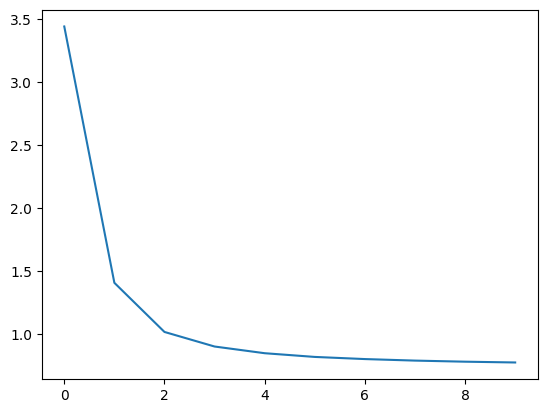

In [11]:
plt.plot(e_loss, label='epoch loss')

## Developing a MF model based using BPR opt


Now we'll generalize the previous implementation using implicit feedback data and applying BPR (Bayesian personalized ranking) loss function, so that the model is capable of building personalzied rankings for users

### Step 1 : adapt training data for BPR


BPR expects implicit feedback data and relative ordering in the training dataset

In [12]:

zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)

bpr_df = generate_bpr_dataset(interactions)

In [13]:
bpr_df["user"].values

array([   1,    1,    1, ..., 6040, 6040, 6040], shape=(3000627,))

### Step 2: Create a MF model using BPR loss function

In [14]:
bpr_df

,user,pos_item,neg_item
0,1,0,1463
1,1,0,3265
2,1,0,152
3,1,1,942
4,1,1,824
...,...,...,...
3000622,6040,152,602
3000623,6040,152,59
3000624,6040,26,2793
3000625,6040,26,2435


In [15]:
data_bpr = bprMFDataloader(bpr_df)


# Calculate split lengths
train_len = int(0.7 * len(data_bpr))
test_len = len(data_bpr) - train_len


train_data, test_data = random_split(data_bpr, [train_len, test_len])



In [16]:


dataloader_bpr_train = DataLoader(train_data, batch_size=256, shuffle=True)
dataloader_bpr_test = DataLoader(test_data, batch_size=256, shuffle=True)

In [17]:

n_users = bpr_df.user.max() + 1
n_items = bpr_df.pos_item.max() + 1

In [18]:
n_users, n_items

(np.int64(6041), np.int64(3706))

In [ ]:



model = bprMf(
                num_users=n_users,
                num_items=n_items,
                factors=30,
                reg_lambda=5e-4,
                n_epochs=10).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train_losses = model.fit(dataloader_bpr_train, optimizer)

In [22]:
train_losses

[0.2907490479390408,
 0.2326867354589944,
 0.22300050291780435,
 0.21864219321611086,
 0.21665254844571671,
 0.2156312521612913,
 0.21475335343137592,
 0.21363357122917134,
 0.21324089038016084,
 0.21248441248551003]

In [23]:
test_loss = model.evaluate(dataloader_bpr_test)

In [24]:
test_loss

0.29625896812502145

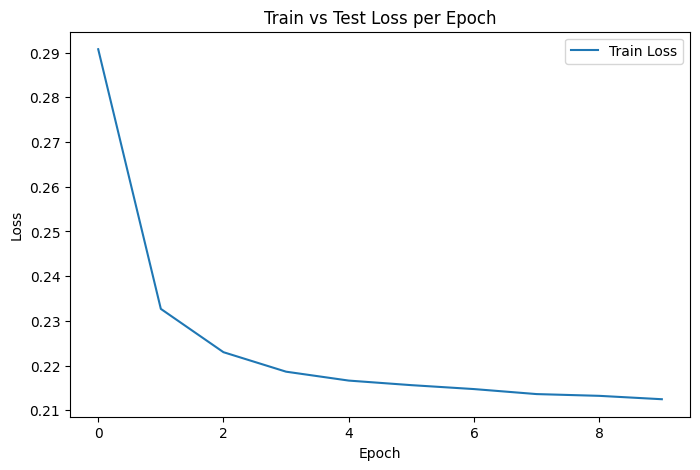

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.show()

## Developing a BPR variant for click position debiasing

In [5]:
from evaluation import Evaluate

In [6]:
interactions = pd.read_csv('movielens_1m_ratings.csv')[["user", "item", "rating"]]
interactions["relevant"] = interactions["rating"].apply(lambda r: int(r >= 4))
zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)


In [7]:
interactions["click"] = np.random.randint(0, 20, size=len(interactions))

In [8]:
interactions

,user,item,rating,relevant,click
0,1,0,5,1,10
1,1,1,3,0,11
2,1,2,3,0,11
3,1,3,4,1,15
4,1,4,5,1,18
...,...,...,...,...,...
1000204,6040,772,1,0,6
1000205,6040,1106,5,1,5
1000206,6040,365,5,1,14
1000207,6040,152,4,1,16


In [9]:

bpr_df_click = generate_bpr_dataset_with_click_data(interactions)

In [10]:
bpr_df_click

,user,pos_item,click_position,neg_item
0,1,0,10,2717
1,1,0,10,2470
2,1,0,10,2897
3,1,1,11,529
4,1,1,11,274
...,...,...,...,...
3000622,6040,152,16,2871
3000623,6040,152,16,1689
3000624,6040,26,14,2075
3000625,6040,26,14,2377


In [11]:
from bpr_mf import bprMFLClickDebiasingDataloader, bprMFWithClickDebiasing

In [12]:
bpr_df_click

,user,pos_item,click_position,neg_item
0,1,0,10,2717
1,1,0,10,2470
2,1,0,10,2897
3,1,1,11,529
4,1,1,11,274
...,...,...,...,...
3000622,6040,152,16,2871
3000623,6040,152,16,1689
3000624,6040,26,14,2075
3000625,6040,26,14,2377


In [13]:
data_bpr = bprMFLClickDebiasingDataloader(bpr_df_click)


train_len = int(0.7 * len(data_bpr))
test_len = len(data_bpr) - train_len


train_data, test_data = random_split(data_bpr, [train_len, test_len])



dataloader_bpr_train = DataLoader(train_data, batch_size=256, shuffle=True)
dataloader_bpr_test = DataLoader(test_data, batch_size=256, shuffle=True)

In [14]:
n_users = bpr_df_click.user.max() + 1
n_items = bpr_df_click.pos_item.max() + 1

In [31]:



model = bprMFWithClickDebiasing(
                num_users=n_users,
                num_items=n_items,
                factors=30,
                reg_lambda=1e-3,
                n_epochs=10).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = model.fit(dataloader_bpr_train, optimizer)

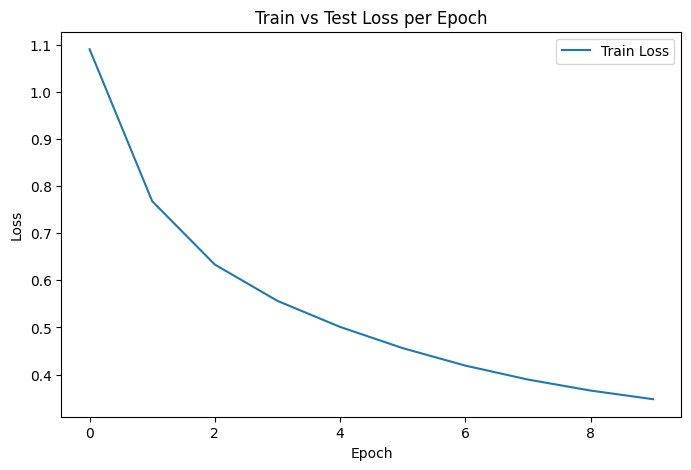

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.show()

In [33]:
test_loss = model.bpr_eval_debiasing(dataloader_bpr_test)

In [34]:
test_loss

0.5673526531090138

In [35]:
evaluator = Evaluate(model, test_data, interactions, k=20)

In [36]:
evaluator.MAP_at_k()

0.10078148578854346